# CNN training on various images with optional additional feature vectors

In [1]:
import os
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Iterable, Tuple, List
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):
    print('Warning: without a GPU the training will take a long time...')


In [2]:
# Constants
IMAGE_SIZE = (256, 256, 3)
NUM_CLASSES = 125
# SKETCH_ROOT = '/Users/taehun.kim/mids/rendered_256x256/256x256/sketch'
SKETCH_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\sketch'
assert os.path.isdir(SKETCH_ROOT)

## Load dataset

### Load image-only dataset

In [52]:
def get_image_dataset(ratios: List[float], augmentations: List[str] = None, color_mode: str = 'rgb',
                    seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # No augmentation by default
    augmentations = augmentations or ['tx_000000000000']

    assert sum(ratios) == 1 and len(ratios) == 3, 'Sum of 3 ratios must add to 1'

    datasets: List[List[tf.data.Dataset]] = []
    for aug in augmentations:
        print(f'Reading images from augmentation {aug}...')
        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = color_mode,
            validation_split = (1 - ratios[0]),
            subset = 'training',
            batch_size=batch_size
        )

        val_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'validation',
            batch_size=batch_size
        )

        val_batch_count = int(tf.data.experimental.cardinality(val_ds))
        test_ds = val_ds.take(int(val_batch_count * ratios[1]))
        val_ds = val_ds.skip(int(val_batch_count * ratios[1]))

        datasets.append([train_ds, val_ds, test_ds])
    
    combined = datasets.pop()
    for train, val, test in datasets:
        combined[0] = combined[0].concatenate(train)
        combined[1] = combined[1].concatenate(val)
        combined[2] = combined[2].concatenate(test)


    def normalize(image, label):
        image = tf.cast(image/255. , tf.float32)
        return image, label

    return [
        d.map(normalize)
        for d in combined
    ]

In [54]:
train_ds, val_ds, test_ds = get_image_dataset([0.8, 0.1, 0.1], augmentations=['tx_000100000000'])

Reading images from augmentation tx_000100000000...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Found 75481 files belonging to 125 classes.
Using 15096 files for validation.


### Load Image dataset with additional numerical features

In [3]:
def get_image_dataset_w_feature(features: np.ndarray, labels: np.ndarray, ratios: List[float], augmentation: str = None, 
                                seed: int = 1, batch_size: int = 32, allow_pickle: bool = False) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # Use centered images by default
    print('Loading images...')
    augmentation = augmentation or 'tx_000100000000'
    img_ds = tf.keras.utils.image_dataset_from_directory(
        directory = os.path.join(SKETCH_ROOT, augmentation),
        image_size = IMAGE_SIZE[:2],
        # We don't want labels to be returned in this dataset
        labels=None,    
        label_mode=None,
        seed = seed,
        color_mode = 'rgb',
        # Don't batch as we want to batch later with others
        batch_size = None,
        # shuffle needs to be False to match the feature vector order
        shuffle=False 
    )
    
    print('Loading feature vector...')
    hog_ds = tf.data.Dataset.from_tensor_slices(features)

    print('Loading labels...')
    num_rows = len(labels)
    num_classes = len(set(labels))
    one_hot = tf.one_hot(labels, num_classes)
    labels_ds = tf.data.Dataset.from_tensor_slices(one_hot)

    combined = tf.data.Dataset.zip(((img_ds, hog_ds), labels_ds))
    shuffled = combined.shuffle(buffer_size=num_rows).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    batch_count = len(shuffled)

    split = []
    for ratio in ratios:
        slice_count = int(batch_count * ratio)
        slice = shuffled.take(slice_count)
        shuffled = shuffled.skip(slice_count)
        split.append(slice)
    
    return split

In [4]:
HOG_INPUT_SIZE = 2048

# Get image + hog dataset
train_ds, val_ds, test_ds = get_image_dataset_w_feature(
    features=np.load(r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\features\hog\hog_features.npz')['arr_0'],
    labels=np.load(r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\features\sift\labels.npz')['arr_0'],
    ratios=[0.8, 0.1, 0.1]
)

Loading images...
Found 75481 files belonging to 1 classes.
Loading feature vector...
Loading labels...


## Build CNN model(s)

In [5]:
def _build_resnet_layers():
    pretrained_resnet = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=IMAGE_SIZE,
        pooling='avg',
        classes=125,
    )
    pretrained_resnet.trainable = False

    tf.keras.backend.clear_session()
    layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_resnet.output)
    layer = tf.keras.layers.Dense(512, activation='relu')(layer)
    return pretrained_resnet.input, layer

def _build_sketch_a_net_layers():
    # Input layer
    inputs = tf.keras.layers.Input(shape=IMAGE_SIZE, name='img_input')
    
    # Convolutional Layer 1
    conv1 = tf.keras.layers.Conv2D(64, (15, 15), activation='relu', padding='valid')(inputs)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv1)
    
    # Convolutional Layer 2
    conv2 = tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='valid')(maxpool1)
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv2)
    
    # Convolutional Layer 3
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(maxpool2)
    
    # Convolutional Layer 4
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(conv3)
    
    # Convolutional Layer 5
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(conv4)
    maxpool5 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv5)
    
    # Flatten
    flatten = tf.keras.layers.Flatten()(maxpool5)
    
    # Fully Connected Layers
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(flatten)
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(512, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    return inputs, dropout2

def build_naive_sketch_a_net():
    cnn_input, cnn_output = _build_sketch_a_net_layers()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_naive_resnet():
    cnn_input, cnn_output = _build_resnet_layers()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_cnn_with_feature(feature_vector_len: int):
    cnn_input, cnn_output = _build_resnet_layers()

    vector_shape = (feature_vector_len)
    vector_input = tf.keras.layers.Input(shape=vector_shape, name='hog_input')

    combined_output = tf.keras.layers.Concatenate()([cnn_output, vector_input])
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(combined_output)
    return tf.keras.Model(inputs=[cnn_input, vector_input], outputs=outputs)

In [56]:
model = build_naive_resnet()

In [6]:
model = build_cnn_with_feature(HOG_INPUT_SIZE)

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Perform training

In [8]:
# Reduce training size on non-powerful machines
reduce_training_size = False
actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

epochs = 10
history = model.fit(
  actual_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
1887/1887 [==============================] - 557s 227ms/step - loss: 2.5821 - accuracy: 0.3788 - val_loss: 1.7785 - val_accuracy: 0.5234
Epoch 2/10
1887/1887 [==============================] - 613s 262ms/step - loss: 1.7516 - accuracy: 0.5277 - val_loss: 1.4435 - val_accuracy: 0.6062
Epoch 3/10
1887/1887 [==============================] - 722s 308ms/step - loss: 1.4807 - accuracy: 0.5845 - val_loss: 1.2431 - val_accuracy: 0.6438
Epoch 4/10
1887/1887 [==============================] - 800s 317ms/step - loss: 1.3065 - accuracy: 0.6233 - val_loss: 1.0800 - val_accuracy: 0.6843
Epoch 5/10
1887/1887 [==============================] - 864s 344ms/step - loss: 1.1662 - accuracy: 0.6559 - val_loss: 1.0112 - val_accuracy: 0.6952
Epoch 6/10
1887/1887 [==============================] - 1116s 398ms/step - loss: 1.0565 - accuracy: 0.6834 - val_loss: 0.8770 - val_accuracy: 0.7460
Epoch 7/10
1887/1887 [==============================] - 1082s 427ms/step - loss: 0.9648 - accuracy: 0.7085 - va

In [9]:
def plot_results(history, show_plot: bool = True):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # Retrieve the training metrics (after each train epoch) and the final test accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Accuracy')
    ax1.plot(train_accuracy, label='train_accuracy')
    ax1.plot(val_accuracy, label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.set_title('Loss')
    ax2.plot(train_loss, label='train loss')
    ax2.plot(val_loss, label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    if show_plot:
        plt.show()

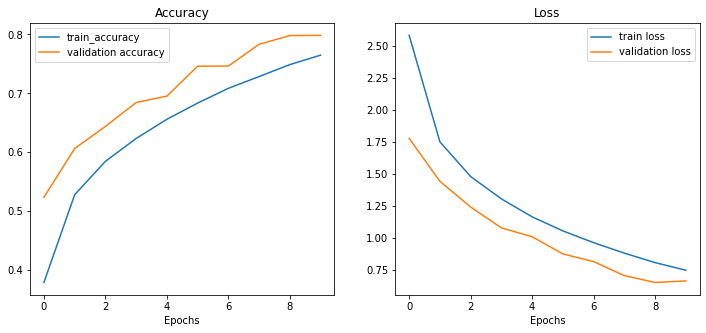

In [10]:
plot_results(history)

## Automate saving experiment results

In [11]:
# Run and save experiment

from typing import Any

RESULTS_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w281-final-project\results'

def run_and_save_experiment(name: str, 
                            model: Any,
                            train_ds: tf.data.Dataset,
                            val_ds: tf.data.Dataset,
                            reduce_training_size: bool = False):
    
    experiment_dir = os.path.join(RESULTS_ROOT, name)
    os.makedirs(experiment_dir, exist_ok=True)

    actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

    epochs = 10
    history = model.fit(
        actual_train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    model.save_weights(os.path.join(experiment_dir, f'{name}_model_weights.h5'))

    plot_results(history, show_plot=False)
    plt.savefig(os.path.join(experiment_dir, f'{name}_history.png'))

    with open(os.path.join(experiment_dir, f'{name}_model_summary.txt'), 'w') as f:
        f.write(f'\nTraining accuracy: {max(history.history["accuracy"])}')
        f.write(f'\nValidation accuracy: {max(history.history["val_accuracy"])}')
    

Epoch 1/10
1888/1888 [==============================] - 308s 162ms/step - loss: 2.8913 - accuracy: 0.2924 - val_loss: 2.3771 - val_accuracy: 0.3832
Epoch 2/10
1888/1888 [==============================] - 253s 134ms/step - loss: 2.0816 - accuracy: 0.4557 - val_loss: 2.1256 - val_accuracy: 0.4506
Epoch 3/10
1888/1888 [==============================] - 251s 133ms/step - loss: 1.8232 - accuracy: 0.5130 - val_loss: 1.8967 - val_accuracy: 0.4974
Epoch 4/10
1888/1888 [==============================] - 258s 136ms/step - loss: 1.6706 - accuracy: 0.5499 - val_loss: 1.7598 - val_accuracy: 0.5385
Epoch 5/10
1888/1888 [==============================] - 257s 136ms/step - loss: 1.5443 - accuracy: 0.5809 - val_loss: 1.8221 - val_accuracy: 0.5299
Epoch 6/10
1888/1888 [==============================] - 244s 129ms/step - loss: 1.4607 - accuracy: 0.5986 - val_loss: 1.6639 - val_accuracy: 0.5647
Epoch 7/10
1888/1888 [==============================] - 249s 132ms/step - loss: 1.3716 - accuracy: 0.6206 - val_

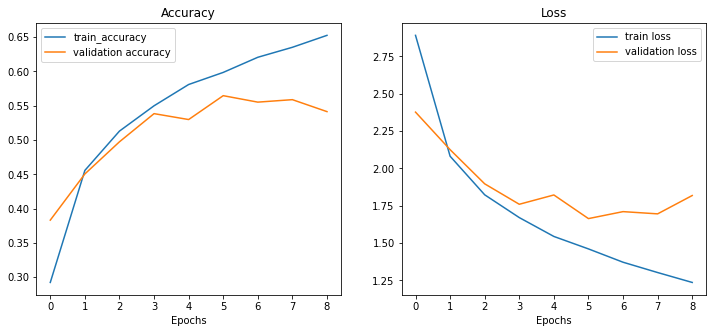

In [60]:
run_and_save_experiment('normalized_resnet_tx_000100000000', model, train_ds, val_ds)